In [1]:
from __future__ import print_function
import keras
from tensorflow.keras.layers import Input,  Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from matplotlib import pyplot as plt

def plotHistoryLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
def plotHistoryAcc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def saveDictionary(dt, file):
        import pickle
        a_file = open(file, "wb")
        pickle.dump(dt, a_file)
        a_file.close()
        
def loadDictionary(file):
        import pickle
        a_file = open(file, "rb")
        dt = pickle.load(a_file)
        return dt
		
def load(model_name, source_token_dict_file,target_token_dict_file,target_token_dict_inv_file ):
        model = keras.models.load_model(model_name)
        s = loadDictionary(source_token_dict_file)
        t = loadDictionary(target_token_dict_file)
        t_inv = loadDictionary(target_token_dict_inv_file)
        return model, s, t, t_inv
		
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 16000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'English2TraChinese.txt'# 'cmn-eng/cmn.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r') as f:
    lines = f.read().split('\n')
for line in lines[0: min(num_samples, len(lines) - 1): 1]: #前面
#for line in lines[-1: -1 - min(num_samples, len(lines) - 1): -1]: #後面
    if len(line)==0: continue
    print("line:", line)
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

2025-05-04 16:05:01.968641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 16:05:02.007314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746345902.036365  239950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746345902.043046  239950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 16:05:02.086143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

line: Hi.	嗨。
line: Hi.	你好。
line: Run.	你用跑的。
line: Wait!	等等！
line: Hello!	你好。
line: I try.	讓我來。
line: I won!	我贏了。
line: Oh no!	不會吧。
line: Cheers!	乾杯!
line: He ran.	他跑了。
line: Hop in.	跳進來。
line: I lost.	我迷失了。
line: I quit.	我退出。
line: I'm OK.	我沒事。
line: Listen.	聽著。
line: No way!	不可能！
line: No way!	沒門！
line: Really?	你確定？
line: Try it.	試試吧。
line: We try.	我們來試試。
line: Why me?	為什麽是我？
line: Ask Tom.	去問湯姆。
line: Be calm.	冷靜點。
line: Be fair.	公平點。
line: Be kind.	友善點。
line: Be nice.	和氣點。
line: Call me.	聯系我。
line: Call us.	聯系我們。
line: Come in.	進來。
line: Get Tom.	找到湯姆。
line: Get out!	滾出去！
line: Go away!	走開！
line: Go away!	滾！
line: Go away.	走開！
line: Goodbye!	再見！
line: Goodbye!	告辭！
line: Hang on!	等一下！
line: He came.	他來了。
line: He runs.	他跑。
line: Help me.	幫我一下。
line: Hold on.	堅持。
line: Hug Tom.	抱抱湯姆！
line: I agree.	我同意。
line: I'm ill.	我生病了。
line: I'm old.	我老了。
line: It's OK.	沒關系。
line: It's me.	是我。
line: Join us.	來加入我們吧。
line: Keep it.	留著吧。
line: Kiss me.	吻我。
line: Perfect!	完美！
line: See you.	再見！
line

I0000 00:00:1746345909.607899  239950 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1746345919.144456  240075 cuda_dnn.cc:529] Loaded cuDNN version 90300


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - acc: 0.0527 - loss: 2.3731 - val_acc: 0.0533 - val_loss: 2.6467
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - acc: 0.0581 - loss: 1.9923 - val_acc: 0.0591 - val_loss: 2.6382
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - acc: 0.0594 - loss: 1.9876 - val_acc: 0.0558 - val_loss: 2.7487
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc: 0.0603 - loss: 2.0081 - val_acc: 0.0610 - val_loss: 2.6385
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - acc: 0.0635 - loss: 1.9786 - val_acc: 0.0590 - val_loss: 2.6507
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - acc: 0.0652 - loss: 1.9660 - val_acc: 0.0641 - val_loss: 2.6167
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - acc: 0.0705 - loss: 1.9510 - val_acc: 0.0771 - val_loss: 2.5856
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc: 0.0738 - loss: 1.9296 - val_acc: 0.0614 - val_loss: 2.6552
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/ste

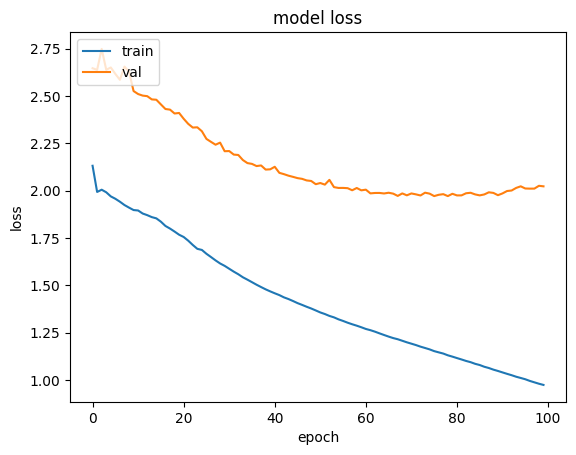

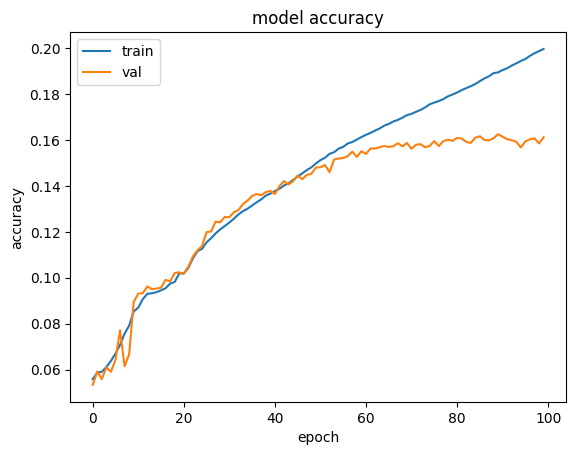

-
Input sentence: Hi.
Decoded sentence: 你。

-
Input sentence: Hi.
Decoded sentence: 你。

-
Input sentence: Run.
Decoded sentence: 走住。

-
Input sentence: Wait!
Decoded sentence: 等好。

-
Input sentence: Hello!
Decoded sentence: 你好。

-
Input sentence: I try.
Decoded sentence: 我走。

-
Input sentence: I won!
Decoded sentence: 我會了。

-
Input sentence: Oh no!
Decoded sentence: 不是。

-
Input sentence: Cheers!
Decoded sentence: 等。

-
Input sentence: He ran.
Decoded sentence: 他跑。

-
Input sentence: Hop in.
Decoded sentence: 真好。

-
Input sentence: I lost.
Decoded sentence: 我愛了。

-
Input sentence: I quit.
Decoded sentence: 我冷。

-
Input sentence: I'm OK.
Decoded sentence: 我很好。

-
Input sentence: Listen.
Decoded sentence: 聽見。

-
Input sentence: No way!
Decoded sentence: 沒！

-
Input sentence: No way!
Decoded sentence: 沒！

-
Input sentence: Really?
Decoded sentence: 你在嗎？

-
Input sentence: Try it.
Decoded sentence: 試！

-
Input sentence: We try.
Decoded sentence: 我們來了。

-
Input sentence: Why me?
Decoded sen

In [2]:
# Import the required Keras layers
from keras.layers import Input, LSTM, Dense
from keras.models import Model
import numpy as np

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
	
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
	
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
          
plotHistoryLoss(history)
plotHistoryAcc(history)

# Save model
model.save('s2s.h5')
saveDictionary(input_token_index, 'input_token_index.pickle')
saveDictionary(target_token_index, 'target_token_index.pickle')
saveDictionary(reverse_target_char_index, 'reverse_target_char_index.pickle')

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, #+ : list concatenation
    [decoder_outputs] + decoder_states)

encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

#The function that translates an input to output sequence
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char #generate the char with the max prob.

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

def test(input_text_example):
    #input_text_example="Tom's daughter pretended not to know him when he came to pick her up from school in his battered old car."
    encoder_input_data_example = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    print(encoder_input_data_example.shape)
    for t, char in enumerate(input_text_example):
      encoder_input_data_example[0, t, input_token_index[char]] = 1.
    decoded_sentence_example = decode_sequence(encoder_input_data_example)
    print('-')
    print('Input sentence:', input_text_example)
    print('Decoded sentence:', decoded_sentence_example)

In [3]:
a=input("enter an english sentence:")
test(a)

(1, 37, 73)
-
Input sentence: hello
Decoded sentence: 你好。



In [4]:
import random

sample_indices = random.sample(range(len(input_texts)), 30)

for idx in sample_indices:
    input_seq = encoder_input_data[idx:idx+1]
    decoded = decode_sequence(input_seq)
    
    print(f"English: {input_texts[idx]}")
    print(f"Translate: {decoded.strip()}")
    print("-" * 60)


English: I woke up at five this morning.
Translate: 我想去約約。
------------------------------------------------------------
English: Father is busy writing letters.
Translate: 父親是一個友友著。
------------------------------------------------------------
English: The policemen arrested the burglar.
Translate: 這個女孩的女孩孩的子子。
------------------------------------------------------------
English: He walked in the park yesterday.
Translate: 他在這裡有一年0。
------------------------------------------------------------
English: You don't seem happy.
Translate: 你不必須。
------------------------------------------------------------
English: It's very kind of you to help me.
Translate: 你想要多點。
------------------------------------------------------------
English: I agreed with him on that point.
Translate: 我同意這個工作。
------------------------------------------------------------
English: Whose shirt is this?
Translate: 這是誰的誰？
------------------------------------------------------------
English: Stop yelling!
Translate: 別再！
--